# Q Learning 실습

In [1]:
# MIT License
#
# Copyright (c) 2016 Matthew Chan
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including wi"t"hout limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

In [2]:
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
os.environ["PATH"] = os.getcwd()+':'+os.environ["PATH"]
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import numpy as np
import math
import random
import gym
import gym_maze
from IPython import display

In [3]:
def select_action(state, explore_rate):
    # Experiment 1, Problem 1: Select action by epsilon greedy
    ########################################
    # "exploration_rate" which is the input attribute of this function
    # is same as the epsilon probability in epsilon-greedy
    ############################ Implement Here ############################
    # Select a random action
    if random.random() < explore_rate:
        action = env.action_space.sample()
    # Select the action with the highest q
    else:
        action = int(np.argmax(q_table[state]))

    return action    
   ########################################################################

In [4]:
def state_to_bucket(state):
    bucket_indice = []
    for i in range(len(state)):
        # len(state) = 2 (cartesian coord)
        if state[i] <= STATE_BOUNDS[i][0]:
            bucket_index = 0
            
        elif state[i] >= STATE_BOUNDS[i][1]:
            bucket_index = NUM_BUCKETS[i] - 1
            
        else:
            # Mapping the state bounds to the bucket array
            bound_width = STATE_BOUNDS[i][1] - STATE_BOUNDS[i][0]
            # bound width = 9.0 for 10x10
            offset = (NUM_BUCKETS[i]-1)*STATE_BOUNDS[i][0]/bound_width
            # offset = 0.0 for 10x10
            scaling = (NUM_BUCKETS[i]-1)/bound_width
            # scaling = 1.0 for 10x10
            bucket_index = int(round(scaling*state[i] - offset))
            # bucket_index <-- changes
            
        bucket_indice.append(bucket_index)
        # bucket_indice is the x,y coordinate of current position(0,0) is the top left corner
        
    return tuple(bucket_indice)

In [5]:
def learn_q_val():
    # Instantiating the learning related parameters
    learning_rate = get_learning_rate(0)
    explore_rate = get_explore_rate(0)
    discount_factor = 0.99
    num_streaks = 0
    
    # If you want to render the maze :
    # env.render()
    # render_img = env.render(mode='rgb_array')
    
    for episode in range(NUM_EPISODES):
        display.clear_output(wait=True)
        # Reset the environment
        obv = env.reset() # obv = [0. 0.]       
        state_0 = state_to_bucket(obv)  # the initial state
        # (0,0)
        total_reward = 0

        for t in range(MAX_T):
            # Select an action
            action = select_action(state_0, explore_rate)
            
            # execute the action
            obv, reward, done, _ = env.step(action)
            # A reward of 1 is given when the agent reaches the goal.
            # For every step in the maze, the agent recieves a reward of -0.1/(number of cells in the maze).
            
            # Observe the result            
            state = state_to_bucket(obv)
            # state: x, y coordinate of the current position.
            # (0,0) is the top left corner
            
            total_reward += reward
            # Experiment 1, Problem 2:  Update the Q based on the transition info
            # state_0: s
            # action: a
            # state: s'
            # reward: r(s,a)
            # best_q: max_a' Q(s',a')
            
            ############################ Implement Here ###################################            
            # best_q: maximum Q-value in the q_table given state(or s' as written in the lecture material)
            
            best_q = np.amax(q_table[state])
            q_table[state_0 + (action,)] += learning_rate * (reward + discount_factor * (best_q) - q_table[state_0 + (action,)])
        
            ########################################################################
            # Setting up for the next iteration
            state_0 = state

            # Print data
            if DEBUG_MODE == 2:
                print("\nEpisode = %d" % episode)
                print("t = %d" % t)
                print("Action: %d" % action)
                print("State: %s" % str(state))
                print("Reward: %f" % reward)
                print("Best Q: %f" % best_q)
                print("Explore rate: %f" % explore_rate)
                print("Learning rate: %f" % learning_rate)
                print("Streaks: %d" % num_streaks)
                print("")

            elif DEBUG_MODE == 1:
                if done or t >= MAX_T - 1:
                    print("\nEpisode = %d" % episode)
                    print("t = %d" % t)
                    print("Explore rate: %f" % explore_rate)
                    print("Learning rate: %f" % learning_rate)
                    print("Streaks: %d" % num_streaks)
                    print("Total reward: %f" % total_reward)
                    print("")                  
              
                if done:
                    print("Episode %d finished after %f time steps with total reward = %f (streak %d)."
                         % (episode, t, total_reward, num_streaks))

                    if t <= SOLVED_T:
                        num_streaks += 1
                    else:
                        num_streaks = 0
                    break

                elif t >= MAX_T - 1:
                    print("Episode %d timed out at %d with total reward = %f."
                         % (episode, t, total_reward))

        # Experiment 1, Problem 3:  Plot state-value table (V-table) with pyplot
        # Assume that we use greedy policy to compute this

        ############################ Implement Here ###################################
        ##### you might have to switch  axis 0 and 1 to match the maze image ##########
        ###############################################################################
        
        v_table = np.amax(np.array(q_table), axis=2)
        v_table = np.swapaxes(v_table, 0, 1)
        
        ###############################################################################
        
        fig = plt.figure()
        ax1 = fig.add_subplot(1, 1, 1)        
        im = ax1.imshow(v_table, cmap='plasma')        
        fig.colorbar(im, orientation='vertical')
        plt.show()
        
        # It's considered done when it's solved over 120 times consecutively
        if num_streaks > STREAK_TO_END:
            break

        # Update parameters
        explore_rate = get_explore_rate(episode)
        learning_rate = get_learning_rate(episode)
#         print(episode)

In [6]:
def get_explore_rate(t):
    return max(MIN_EXPLORE_RATE, min(0.8, 1.0 - math.log10((t+1)/DECAY_FACTOR)))

In [7]:
def get_learning_rate(t):
    return max(MIN_LEARNING_RATE, min(0.8, 1.0 - math.log10((t+1)/DECAY_FACTOR)))

In [8]:
# Initialize the "maze" environment
env = gym.make("maze-sample-10x10-v0")

'''
Defining the environment related constants
'''

# Number of discrete states (bucket) per state dimension
MAZE_SIZE = tuple((env.observation_space.high + np.ones(env.observation_space.shape)).astype(int))
NUM_BUCKETS = MAZE_SIZE  # one bucket per grid
NUM_ACTIONS = env.action_space.n  # ["N", "S", "E", "W"]
STATE_BOUNDS = list(zip(env.observation_space.low, env.observation_space.high))

'''
Learning related constants
'''
MIN_EXPLORE_RATE = 0.001
MIN_LEARNING_RATE = 0.2
DECAY_FACTOR = np.prod(MAZE_SIZE, dtype=float) / 10.0

'''
Defining the simulation related constants
'''
NUM_EPISODES = 1000
MAX_T = np.prod(MAZE_SIZE, dtype=int) * 100
STREAK_TO_END = 100

# If the agent has executed action as much as the number of discrete positions (SOLVED_T) in the maze
# and still have not found the exit, then streak increases.
SOLVED_T = np.prod(MAZE_SIZE, dtype=int)
DEBUG_MODE = 1
RENDER_MAZE = True

'''
Creating a Q-Table for each state-action pair
'''
q_table = np.zeros(NUM_BUCKETS + (NUM_ACTIONS,), dtype=float)


pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: Environment '<class 'gym_maze.envs.maze_env.MazeEnvSample10x10'>' has deprecated methods '_step' and '_reset' rather than 'step' and 'reset'. Compatibility code invoked. Set _gym_disable_underscore_compat = True to disable this behavior.



Episode = 152
t = 61
Explore rate: 0.001000
Learning rate: 0.200000
Streaks: 100
Total reward: 0.939000

Episode 152 finished after 61.000000 time steps with total reward = 0.939000 (streak 100).


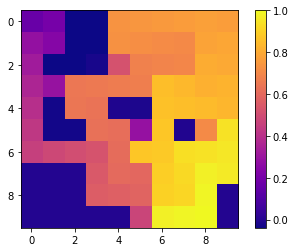

In [9]:
learn_q_val()

In [10]:
# Render & Evaluate agent
obs, done = env.reset(), False
episode_rew = 0

while not done:
    obs, rew, done, _ = env.step( select_action(state_to_bucket(obs), 0.0) )
    episode_rew += rew
print("Episode reward", episode_rew)

Episode reward 0.939
